## Transfer Learning Tuning:
  * Use Resnet50 to reduce model size and improve accuracy 
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
      * [resnet50 blog](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL) 
  * top_model: tune dense layers (parameters are inspired by a few sources)
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)



  
---
#### This cell is required in order to use GPU for running the model 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
keras.backend.get_session().run(tf.global_variables_initializer())  

Using TensorFlow backend.


---
#### Import necessary libraries

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model, model_from_json
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#  import total dataframe

df = pd.read_pickle('../pickle_files/pic_df.pkl')

In [4]:
# set each column as string for dataprocessing 
df = df.astype('str')

In [5]:
df = df.reset_index().rename(columns = {'index':'pic_id'}) # try to predict on the whole data frame 

In [6]:
df.head()

,pic_id,eyewear,hat,beard
0,00018.jpg,0,0,1
1,00034.jpg,0,0,1
2,00048.jpg,1,0,0
3,00053.jpg,1,0,0
4,00061.jpg,1,0,0


In [7]:
# subset a dataframe 
def create_test_train(df,label):
    '''
    df: dateframe of pic_ids 
    label: eyewear,hat, or beard, a string
    return: test and train df
    '''
    sub_set = df[['pic_id',label]]  # subset the label dataframe 
    X_train, X_test, y_train, y_test = train_test_split(sub_set['pic_id'], sub_set[label],
                                                        stratify = sub_set[label],
                                                        test_size = 0.2)
    df_train = pd.concat([X_train,y_train], axis=1)
    df_test = pd.concat([X_test,y_test], axis=1)
    return df_train, df_test
    

In [8]:
def create_generator(train_df, test_df,label,shuffle,batch_size,
                    rescale, preprocess_func, target_size,
                    class_mode):
    '''
    train_df, test_df: dataframe for train and test 
    label: eyewear,hat, or beard, a string
    shuffle: weather to shuffle or not based upon feature extractor or not 
    batch_size: how many pictures per batch
    preprocess_func: vgg16 preprocess or ResNet50
    rescale: 1./255 or None
    target_size: (224,224) or (150,150)
    class_mode: none or binary 
    return:
    train generator and test generator 
    '''
    traingen = ImageDataGenerator(
        rescale = rescale,
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        brightness_range=[0.5,1.5],
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_func)
        
    train_generator = traingen.flow_from_dataframe(
        dataframe=train_df,
        directory='../data/pics',
        x_col='pic_id',
        y_col=label,
        batch_size=batch_size,
        shuffle = shuffle,
        target_size=target_size,
        class_mode = class_mode)
    
    testgen = ImageDataGenerator(
        rescale = rescale,
        preprocessing_function=preprocess_func)
    
    test_generator = testgen.flow_from_dataframe(
        dataframe=test_df,
        directory='../data/pics',
        x_col='pic_id',
        y_col=label,
        batch_size=batch_size,
        shuffle=shuffle,
        target_size=target_size,
        class_mode=class_mode)
    return train_generator, test_generator

# class_weights = class_weight.compute_class_weight(
#           'balanced',
#            np.unique(train_generator.classes),
#            train_generator.classes)


In [9]:
train_df, test_df = create_test_train(df,'eyewear')

In [43]:
train_generator, test_generator = create_generator(train_df=train_df,
                                                   test_df=test_df,
                                                   label='eyewear',
                                                   shuffle=False,
                                                   rescale=None,
                                                   preprocess_func=preprocess_input,
                                                   batch_size=16,
                                                   target_size=(224,224),
                                                   class_mode='binary')                                                               

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


In [44]:
# calculate class weights 
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes),
                                                  train_generator.classes)

In [47]:
class_weights

array([1.03162055, 0.97026022])

---
#### Import train_df and test_df

In [48]:
# def load_df(label):
#     '''
#     label: eyewear,beard, or hat a string
#     return train and test df 
#     '''
#     if label == 'eyewear':
#         train_df = pd.read_pickle('../pickle_files/train_df_glasses.pkl')
#         test_df = pd.read_pickle('../pickle_files/test_df_glasses.pkl')
#     if label == 'beard':
#         train_df = pd.read_pickle('../pickle_files/train_df_beard.pkl')
#         test_df = pd.read_pickle('../pickle_files/test_df_beard.pkl')
#     if label == 'hat':
#         train_df = pd.read_pickle('../pickle_files/train_df_hat.pkl')
#         test_df = pd.read_pickle('../pickle_files/test_df_hat.pkl')
#     return train_df, test_df     

In [49]:
# train_df, test_df = load_df('beard')

In [50]:
# train_df.head()

#### Get bottleneck features to tune top models

In [10]:
def save_bottleneck_features(df, label, batch_size, model_type, preprocess_func, rescale,
                            shuffle,target_size,class_mode):
    '''
    inputs:
    df: dataframe for all eyewear, hat, and beard 
    label: a string, eyewear, hat, or beard
    batch_size: process images in batches
    model_type: ResNet50 or VGG16
    shuffle: weather to shuffle or not based upon feature extractor or not 
    preprocess_func: vgg16 preprocess or ResNet50
    rescale: 1./255 or None
    target_size: (224,224) or (150,150)
    class_mode: none or binary 
    outputs:
    saves bottleneck features inside folder tuning_data as npy file
    '''
    # intialize the model, vgg16 or ResNet50 
    # make sure not to train the top layers 
    base_model = model_type(weights = 'imagenet',include_top = False)
    # generate test_train df
    train_df, test_df = create_test_train(df,label)
    # create train_generator and test_generator to get bottleneck inputs for train and test df 
    # make sure shuffle is False so we know the label follows the sequence of the dataframe 
    # so we can tune top_model 
    train_generator, test_generator = create_generator(train_df=train_df,
                                                   test_df=test_df,
                                                   label=label,
                                                   shuffle=shuffle,
                                                   rescale=rescale,
                                                   preprocess_func=preprocess_input,
                                                   batch_size=16,
                                                   target_size=target_size,
                                                   class_mode=class_mode)  
    # get features saved as .npy in tunign_data folder 
    bottleneck_features_train = base_model.predict_generator(
        train_generator, train_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/resnet_data/untracked_resnet50/bottleneck_features_train_{label}_resnet50_beta.npy','wb'),
           bottleneck_features_train)
    
    bottleneck_features_test = base_model.predict_generator(
        test_generator, test_df.shape[0]//batch_size)
    np.save(open(f'../tuning_data/resnet_data/untracked_resnet50/bottleneck_features_test_{label}_resnet50_beta.npy','wb'),
           bottleneck_features_test)
    return train_df, test_df

#### Save bottleneck_features

In [ ]:
save_bottleneck_features(df,'eyewear',16,ResNet50,preprocess_input,
                         None,False,(224,224),None)

### Quick tuning of top models 

In [ ]:
def train_top_model_ResNet50(train_df, test_df, epoch, batch_size, label):
    '''
    inputs:
    train_df, test_df: dataframes returned from save_bottleneck_features functions 
    epoch: num of epochs in fit 
    batch_size: same as image generator batch size 
    label: a string, eyewear, hat, or beard
    output:
    saves model weights in a folder 
    '''
    train_data = np.load(open(f'../tuning_data/resnet_data/untracked_resnet50/bottleneck_features_train_{label}_resnet50_beta.npy','rb'))
    # make sure train_data and train_label have same num of samples
    train_label = np.array(train_df[label].map({'not_'+label:0, label:1}))[:-(train_df.shape[0]%batch_size)]
    
    test_data = np.load(open(f'../tuning_data/resnet_data/untracked_resnet50/bottleneck_features_test_{label}_resnet50_beta.npy','rb'))
    test_label = np.array(test_df[label].map({'not_'+label:0, label:1}))[:-(test_df.shape[0]%batch_size)]
    
    # build top model
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer= optimizers.Adam(),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/resnet_data/untracked_resnet50/best_bottleneck_resnet50_model_{label}_beta.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    model.fit(train_data, train_label,
             epochs=epoch,
             batch_size=batch_size,
             validation_data=(test_data,test_label),
             callbacks=callbacks_list)
    del model
    keras.backend.clear_session()

#### run train_top_model and save results in tuning_data

In [ ]:
train_top_model(train_df, test_df, 100, 16, 'eyewear')

### Fine Tune Top Model to improve accuracy

In [116]:
def fine_tune_model(train_df, test_df,epoch, batch_size,label, print_model = True):
    # build VGG16 model and freeze top layers
    # input_shape: width, height, RGB (from image generator)
    model_resnet50 = ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
    # build top model
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D(input_shape=model_resnet50.output_shape[1:]))
    top_model.add(Dense(512,activation='relu'))
    top_model.add(Dropout(0.25))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # load saved weights to fine tune parameters 
    top_model.load_weights(f'../tuning_data/resnet_data/untracked_resnet50/best_bottleneck_resnet50_model_{label}.h5')
    # add top model to model
    model = Model(inputs=model_resnet50.input, outputs=top_model(model_resnet50.output))
    # we will tune last 8 layers of the model: activation49 and fully connected layer 
    for layer in model.layers[:-8]:
        layer.trainable = False
    # we can tune the parameters for lr and momentum later to get better results
    model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(lr=5e-5, momentum = 0.9),
             metrics=['accuracy'])
    # prepare train generator using data augmentation to battle small sample size 
    train_gen = ImageDataGenerator(
        zoom_range= [0.8,1.7],
        shear_range=0.2,
        rotation_range = 40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        preprocessing_function=preprocess_input)
    # not want to augment the test 
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_generator =  train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode = 'binary')
    
    test_generator =  test_gen.flow_from_dataframe(
    dataframe=test_df,
    directory='../data/pics',
    x_col='pic_id',
    y_col=label,
    batch_size=batch_size,
    target_size=(224,224),
    class_mode = 'binary')
    
    # checkpoint for best weights 
    filepath=f"../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_8_layer_{label}_0.25do.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    # run and fit model 
    result = model.fit_generator(
    train_generator,
    steps_per_epoch=train_df.shape[0]//batch_size,
    epochs=epoch,
    validation_data=test_generator,
    validation_steps=test_df.shape[0]//batch_size,
    verbose=1,
    callbacks=callbacks_list)
    
    if print_model:
        model.summary()
    
    del model
    keras.backend.clear_session()
    return result                

### save model history 

In [117]:
model_history = fine_tune_model(train_df, test_df,100,16,'beard', False)

Found 363 validated image filenames belonging to 2 classes.
Found 91 validated image filenames belonging to 2 classes.
Epoch 1/100
22/22 [==============================] - 5s 233ms/step - loss: 4.5504 - acc: 0.2437 - val_loss: 5.8995 - val_acc: 0.0875

Epoch 00001: val_acc improved from -inf to 0.08750, saving model to ../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_8_layer_beard_0.25do.h5
Epoch 2/100
22/22 [==============================] - 4s 200ms/step - loss: 3.8024 - acc: 0.2359 - val_loss: 5.4729 - val_acc: 0.0533

Epoch 00002: val_acc did not improve from 0.08750
Epoch 3/100
22/22 [==============================] - 4s 195ms/step - loss: 3.2095 - acc: 0.1633 - val_loss: 4.6971 - val_acc: 0.0800

Epoch 00003: val_acc did not improve from 0.08750
Epoch 4/100
22/22 [==============================] - 4s 179ms/step - loss: 2.7993 - acc: 0.1534 - val_loss: 4.1538 - val_acc: 0.0267

Epoch 00004: val_acc did not improve from 0.08750
Epoch 5/100
22/22 [==================


Epoch 00034: val_acc did not improve from 0.76000
Epoch 35/100
22/22 [==============================] - 4s 191ms/step - loss: 0.4848 - acc: 0.8153 - val_loss: 0.5255 - val_acc: 0.7467

Epoch 00035: val_acc did not improve from 0.76000
Epoch 36/100
22/22 [==============================] - 4s 167ms/step - loss: 0.4785 - acc: 0.8272 - val_loss: 0.5257 - val_acc: 0.7600

Epoch 00036: val_acc did not improve from 0.76000
Epoch 37/100
22/22 [==============================] - 4s 197ms/step - loss: 0.4931 - acc: 0.7983 - val_loss: 0.4969 - val_acc: 0.7500

Epoch 00037: val_acc did not improve from 0.76000
Epoch 38/100
22/22 [==============================] - 4s 183ms/step - loss: 0.4691 - acc: 0.8398 - val_loss: 0.5148 - val_acc: 0.7200

Epoch 00038: val_acc did not improve from 0.76000
Epoch 39/100
22/22 [==============================] - 4s 185ms/step - loss: 0.4437 - acc: 0.8595 - val_loss: 0.4203 - val_acc: 0.8667

Epoch 00039: val_acc improved from 0.76000 to 0.86667, saving model to ../

Epoch 75/100
22/22 [==============================] - 4s 179ms/step - loss: 0.3052 - acc: 0.9021 - val_loss: 0.2451 - val_acc: 0.8800

Epoch 00075: val_acc did not improve from 0.94667
Epoch 76/100
22/22 [==============================] - 4s 171ms/step - loss: 0.2762 - acc: 0.8993 - val_loss: 0.2948 - val_acc: 0.8933

Epoch 00076: val_acc did not improve from 0.94667
Epoch 77/100
22/22 [==============================] - 4s 193ms/step - loss: 0.2997 - acc: 0.8936 - val_loss: 0.2501 - val_acc: 0.9333

Epoch 00077: val_acc did not improve from 0.94667
Epoch 78/100
22/22 [==============================] - 4s 177ms/step - loss: 0.2701 - acc: 0.9148 - val_loss: 0.2232 - val_acc: 0.9200

Epoch 00078: val_acc did not improve from 0.94667
Epoch 79/100
22/22 [==============================] - 4s 188ms/step - loss: 0.2734 - acc: 0.9000 - val_loss: 0.2623 - val_acc: 0.9125

Epoch 00079: val_acc did not improve from 0.94667
Epoch 80/100
22/22 [==============================] - 5s 207ms/step - loss:

In [118]:
highest_val_acc, highest_train_acc = max(model_history.history['val_acc']), max(model_history.history['acc'])
print(f'highest test accuracy: {highest_val_acc}')
print('------------------')
print(f'highest train accuracy: {highest_train_acc}')

highest test accuracy: 0.9466666706403096
------------------
highest train accuracy: 0.9538904897417734


In [119]:
lowest_val_loss, lowest_train_loss = min(model_history.history['val_loss']), min(model_history.history['loss'])
print(f'lowest test loss: {lowest_val_loss}')
print('------------------')
print(f'lowest train loss: {lowest_train_loss}')

lowest test loss: 0.16835455457369486
------------------
lowest train loss: 0.22229859164194002


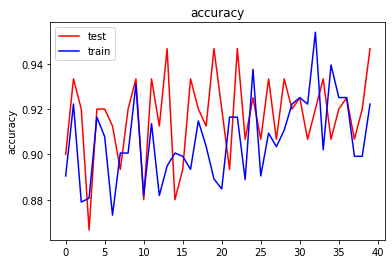

In [120]:
plt.plot(model_history.history['val_acc'][-40:], color = 'red', label = 'test')
plt.plot(model_history.history['acc'][-40:], color = 'blue', label = 'train')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.legend()
plt.show()

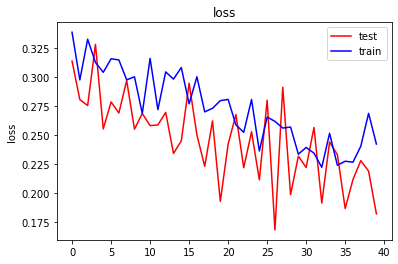

In [121]:
plt.plot(model_history.history['val_loss'][-40:], color = 'red', label = 'test')
plt.plot(model_history.history['loss'][-40:], color = 'blue', label = 'train')
plt.title('loss')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
model_history.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### Save model 

In [15]:
# # save model artchitecture 
# resnet50_model_8_up = model_history.model
# resnet50_model_8_up_json = resnet50_model_8_up.to_json()

In [16]:
# # serialize model to JSON
# with open("../tuning_data/resnet_data/resnet50_model_8_up.json", "w") as json_file:
#     json_file.write(resnet50_model_8_up_json)

### Testing model

In [17]:
train_df, test_df = load_df('eyewear')
df = pd.concat([train_df,test_df])
df.head()

,pic_id,eyewear
235,00964.jpg,not_eyewear
171,00872.jpg,not_eyewear
372,00412.jpg,eyewear
93,00745.jpg,not_eyewear
142,00822.jpg,not_eyewear


In [18]:
# load json and create model
def model_testing(model_path, weight_path, label):
    '''
    model_path: json model path
    weight_path: path for weights 
    label: eyewear, hat, or beard
    '''
    train_df, test_df = load_df(label)
    df = pd.concat([train_df,test_df])
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load model weight yewear_decay_
    loaded_model.load_weights(weight_path)
    # test test data
    data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    data_generator = data_gen.flow_from_dataframe(
        dataframe=df,
        directory='../data/pics',
        x_col='pic_id',
        y_col=label,
        batch_size=300,
        target_size=(224,224),
        class_mode = 'binary',
        shuffle = False
    )
    labels = df[label].map({f'not_{label}':1, f'{label}':0})
    
    loaded_model.compile(loss='binary_crossentropy',
             optimizer=optimizers.SGD(),
             metrics=['accuracy']
                        )
    y_pred = np.around(loaded_model.predict_generator(data_generator, workers=8))
    fpr, tpr, thresholds = roc_curve(labels, y_pred)
    area = roc_auc_score(labels, y_pred)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print(confusion_matrix(labels, y_pred))
    print(classification_report(labels, y_pred))    

Found 632 validated image filenames belonging to 2 classes.


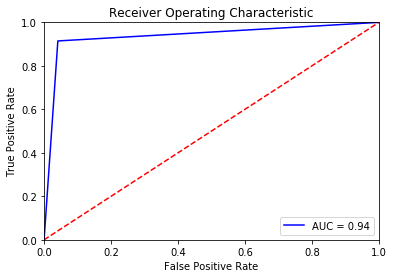

[[303  13]
 [ 27 289]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       316
           1       0.96      0.91      0.94       316

    accuracy                           0.94       632
   macro avg       0.94      0.94      0.94       632
weighted avg       0.94      0.94      0.94       632



In [19]:
model_testing('../tuning_data/resnet_data/resnet50_model_8_up.json', 
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_8_layer_eyewear_0.5do.h5',
              'eyewear')
# keep best_resnet50_model_8_layer_eyewear_0.5do.h5

Found 632 validated image filenames belonging to 2 classes.


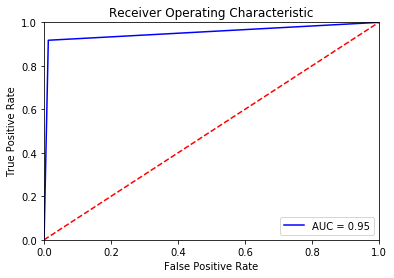

[[312   4]
 [ 26 290]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       316
           1       0.99      0.92      0.95       316

    accuracy                           0.95       632
   macro avg       0.95      0.95      0.95       632
weighted avg       0.95      0.95      0.95       632



In [20]:
model_testing('../tuning_data/resnet_data/resnet50_model_5_up.json', 
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_eyewear.h5',
              'eyewear')

### Testing hat 

Found 510 validated image filenames belonging to 2 classes.


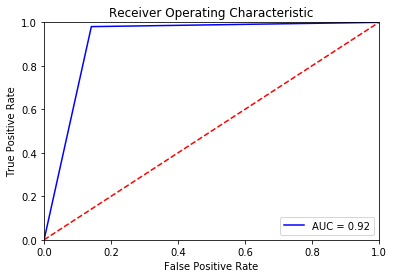

[[219  36]
 [  5 250]]
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       255
           1       0.87      0.98      0.92       255

    accuracy                           0.92       510
   macro avg       0.93      0.92      0.92       510
weighted avg       0.93      0.92      0.92       510



In [21]:
model_testing('../tuning_data/resnet_data/resnet50_model_8_up.json',
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_8_layer_hat_0.25do.h5','hat')

# hat doesn't have enough data for tuning 

Found 510 validated image filenames belonging to 2 classes.


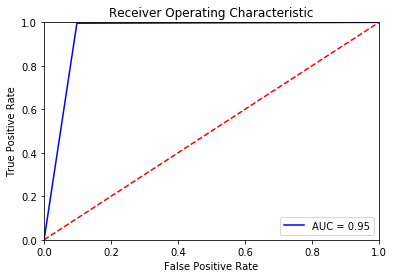

[[230  25]
 [  1 254]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       255
           1       0.91      1.00      0.95       255

    accuracy                           0.95       510
   macro avg       0.95      0.95      0.95       510
weighted avg       0.95      0.95      0.95       510



In [23]:
model_testing('../tuning_data/resnet_data/resnet50_model_8_up.json', 
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_hat.h5',
             'hat')

### Testing beard

Found 454 validated image filenames belonging to 2 classes.


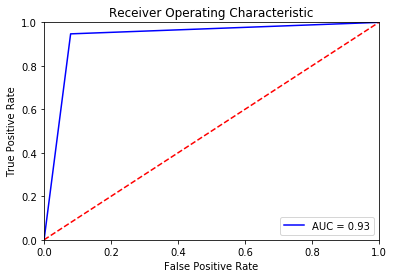

[[209  18]
 [ 12 215]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       227
           1       0.92      0.95      0.93       227

    accuracy                           0.93       454
   macro avg       0.93      0.93      0.93       454
weighted avg       0.93      0.93      0.93       454



In [24]:
model_testing('../tuning_data/resnet_data/resnet50_model_8_up.json',
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_8_layer_beard_0.25do.h5','beard')

Found 454 validated image filenames belonging to 2 classes.


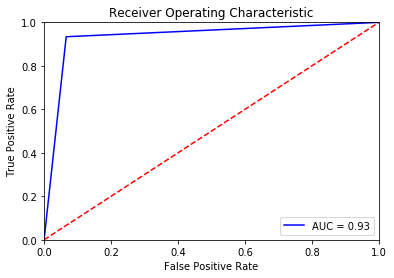

[[212  15]
 [ 15 212]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       227
           1       0.93      0.93      0.93       227

    accuracy                           0.93       454
   macro avg       0.93      0.93      0.93       454
weighted avg       0.93      0.93      0.93       454



In [25]:
model_testing('../tuning_data/resnet_data/resnet50_model_5_up.json',
              '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_beard.h5','beard')